**Institution**: UNSW

**Faculty**: Faculty of Engineering, School of Computer Science and Engineering

**Course**: Neural Networks, Deep Learning

**Course code**: ZZEN9444 

**Title**: Writing Neural Networks - Language processing

**Author**: Mohammad Hosseinzadeh

**Student ID**: z5388543

**Date**: 10 October 2021

**Course coordinator**: Dr. Alan Blair

---

# Table of Contents
* [Data preprocessing](#pre)
* [Prediction output conversion](#conv)
* [Recurrent Neural Network - LSTM](#rnn)
* [Bi-LSTM architecture](#lstm)
* [Overfitting](#fit)
* [Cost function](#cost)
* [Optimizer](#optim)
* [Results](#results)
* [References](#ref)

---

# Data preprocessing <a class="anchor" id="pre"></a> 

The following objects are required for data preparation in sentiment analysis task when using *torchtext.data*:

- **Field**: specifies how to preprocess each data column in our dataset.
- **LabelField**: defines the label in the classification task.

The *main()* function in *a3main.py* script defines our *Field* and *LabelField* objects. We have defined the *Field* object to convert strings to lower case by passing *lower=True* argument. We have also set *include_length=True* to allow for dynamic padding by adding the lengths of the reviews to the dataset. In addition to the *Field* object, a *preprocessing()* function has been defined in *student.py* to perform the following additional preprocessing of the data using the regular expression package, *re*:

- remove html mark tags
- remove non-ascii and digits
- remove unwanted characters
- remove extra white spaces.

The *preprocessing()* function will be called after tokenising but prior to numericalising to perform the text cleaning task.

The model uses Global Vectors for Word Representation (GloVe 6B) unsupervised learning algorithm for obtaining vector representation for words (Pennington et al. 2014). GloVe is used for word embedding for text where it allows for words with similar meaning to have similar representation. The dimension of the vector was chosen to be 300 as the increase in dimension allows the vector to capture more information. For this task, dimension of 300 was found to perform better when we experimented with different dimension values (50, 150, 200, 250). However, it should be noted that increases in dimension size will result in greater computational complexity. 

# Prediction output conversion <a class="anchor" id="conv"></a>

We must ensure the output of our network is in the same Tensor data type (LongTensor) of the *rating* and *businessCategory* of *dataset* as defined by *main()* function in *a3main.py*. This has been achieved by defining *convertNetOutput(ratingOutput, categoryOutput)* function to process the prediction label data. 

Our model uses sigmoid activation function which outputs *FloatTensor* data type values between 0 and 1 to predict ratings. In this sentiment analysis task, our model is required to predict whether the review texts are negative or positive. Therefore, the ratings prediction is a binary classification task where it only requires to take on the value of 0 (negative) or 1 (positive). We can thus ensure the prediction label for *ratingOutput* is in *LongTensor* data type by applying the following process:

- *ratingOutput = torch.tensor([1 if x > 0.5 else 0 for x in ratingOutput]).to(device)*
- prediction values over 0.5 given by our model will be assessed as positive and assigned 1 (integer64/long data type)
- prediction values below 0.5 given by our model will be assessed as negative and assigned 0 (integer64/long data type).

The business categories target class labels in our dataset are [0, 1, 2, 3, 4], which represent restaurants, shopping, home services, health and medical, and automotive respectively. Our model uses the *CrossEntropyLoss()* loss function, which combines log softmax loss function and negative log-likelihood and outputs a probability distribution between 0 and 1. Therefore, the predicted label with the highest probability was assigned to the target class by applying the following conversion process:

- *categoryOutput = tnn.Softmax(categoryOutput, dim=1)* 
- *categoryOutput = torch.argmax(categoryOutput, dim=1)*.

Prior to assigning a class label to the model's prediction *tnn.Softmax()* function is applied to to ensure the values lie in the range [0, 1] which can be interpreted as a probability distribution. Subsequently, the *torch.argmax()* function will return the indices of the maximum values of the category prediction output tensor in LongTensor data type representing the label with the highest probability (Paszke et al. 2019).    

# Recurrent Neural Network - LSTM <a class="anchor" id="rnn"></a>

The recurrent neural network model used to perform this task is a long short-term memory (LSTM) network. This type of network is preferred over simple recurrent networks (SNR) as it can avoid both vanishing and exploding gradients associated with SNRs. LSTM networks are able to learn long range dependencies by using a combination of three internal neural networks: forget, input and output gates. Each of these gates is a feed forward network layer which are made of weights that the network will learn, as well as an activation function (Lane et al. 2019). 

The *forget gate* is used to determine a ratio between 0 and 1 for each cell unit $C_{t-1}$. If the ratio is close to zero, the previous value of the corresponding cell unit will be mostly forgotten. Whereas, a ratio close to one will mostly preserved the previous value. The *torch.nn.LSTM()* function from *PyTorch* computes the forget gate function using the following formula: 

$$f_t = \sigma (W_f . [h_{t-1}, X_t] + b_f)$$ 

The activation function for this gate is a *sigmoid* activation function, which outputs values between 0 and 1 for each cell unit.  

The next step is to decide what new information we will add to the cell unit (i.e. update values). The update values $(g)$ are between -1 and +1, which are computed using *tanh*, and the *input gate $(i)$* is used to determine the ratios by which these update values will be multiplied before being added to the current cell unit values. This is represented by the following mathematical formulas:

$$i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$g_t = tanh(W_g \cdot [h_t-1, x_t] + b_g)$$

The cell unit value is then updated by combining the input gate ($i_t$) and tanh ($g_t$) and doing an element-wise multiplication between the forget gate ($f_t$) and the sum product of this, as shown by the following formula:

$$c_t = f_t \cdot c_{t-1} + i_t \cdot g_t$$

The final *output* gate $(0)$ computes the ratios by which tanh of the cell unit values will be multiplied with the aim of producing the next hidden unit values with the following mathematical formula:

$$o_t =\sigma (W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \cdot tanh(c_t)$$

This type of network allows the cell unit to specialise, with some changing their values regularly while others preserving their state for many iterations.

# Bi-LSTM architecture <a class="anchor" id="lstm"></a>

Through experimentation, the following LSTM network architecture consistently produced satisfactory performance:

- batch size = 32
- bidirectional
- two recurrent layers, stacked LSTM
- input size of 300 characters long
- 148 features in each hidden state
- 1 x fully connected hidden layer - 200 x 2 as input and 100 outputs
- ReLU activation function
- dropout - 30%
- 1 x fully connected **rating** output layer - 100 inputs, 1 output for binary classification
- sigmoid activation function to ensure predicted values are between 0 and 1 
- 1 x fully connected **category** output layer - 100 inputs, 5 outputs. No activation function follows this layer as we are using *CrossEntropyLoss()*. 

A Bidirectional LSTM network was chosen as it increases the amount of information to the network and provides additional context to the sequence. In Bi-LSTM, two independent networks are created where one gets the sequence in their natural order, while the other gets the sequence in their reverse order. This can help improve performance on sequence classification tasks.

Depth was added to our model by forming a two layer stacked LSTM. Increasing depth of a network can be viewed as a type of representational optimization. This can provide a model that requires fewer neurons to train and increasing computational efficiency by reducing training execution time.

Weight initialisation was also used to enhance the performance of our model. Teaching a neural network involves gradually improving network weights to minimize a loss function, resulting in a set of weights that can make optimal predictions (Glassner 2021). This process begins when initial values are assigned to the weights. In practice, weight initialisation has a major impact on the efficiency and performance of the model.    

For Rectified Linear Units (ReLU) it is recommended to use kaiming initialisation as shown by He et al. (2015), where the weights are chosen from Gaussian distribution with mean 0 and standard deviation $\frac{\sqrt{2}}{\sqrt{n_i}}$.    

# Overfitting <a class="anchor" id="fit"></a>

To avoid our model from overfitting the data, the regularization methods dropout and weight decay were applied. When applying dropout, the dropout layer will temporarily disconnect some of the units inputs and outputs from the previous layer. Once the batch is completed, these units and all of their connections are restored. At the beginning of the next batch, a new random set of units are temporarily removed with this process repeating itself for each epoch. Dropout can delay overfitting as it prevents any unit from over-specialising on the training data. 

Weight decay, also known as L2 regularization, is another method used for regularising machine learning models. This is achieved by adding a penalty term to the loss function, which encourages the network weights to remain small. Weight decay indicates a Gaussian prior over the model parameters resulting in regularisation of the networks complexity (Graves 2011).

To evaluate the training of our network and obtain an estimate on the model's performance, we split the input data into a training set and validation set with 80% assigned to training and 20% assigned to validation. Subsequently, we obtain an estimate on the network's performance by making predictions for the validation set. This allows us to experiment with different hyperparameters and choose the best ones based on their performance on the validation set and help improve generalisation. Once the optimal parameters where found and we were confident that the model can generalise, the network was run on the complete training dataset. More training data helped increase the accuracy, specially when predicting business categories.     

# Cost function <a class="anchor" id="cost"></a>

A cost function compares how far off a prediction is from its target in the training data and presents a real value score called the *loss*. The higher this score, the worse the network's prediction is. For tasks such as regression, MSE cost is preferred. However, it has a vital flaw in which neuron saturation can occur. This can negatively impact neural networks ability to learn. An alternative cost function is cross-entropy which is well suited to classification tasks. Cross-entropy loss function estimates the probability of a predicted label belonging to the target class label and leads to faster learning as well improved generalisation for classification problems. 

For the binary classification tasks such as rating prediction, the binary cross-entropy loss function can be applied. For implementation in PyTorch, the *nn.BCELoss()* function is used. To convert the subsequent output probabilities into two discrete classes, we can apply a decision boundary of 0.5. If the predicted probability is above 0.5, the predicted class is 1 (positive); otherwise the class is 0 (negative). The decision boundary value can also be tuned as a hyperparameter to achieve the desired accuracy.  

For a multi-class classification task such as predicting business categories, *nn.CrossEntropyLoss()* can be used. The outputs of this function can be interpreted as prediction probabilities of belonging to a target class label. Our aim is to have the probability of the correct class to be close to 1, with the other classes being close to 0. The target class with the highest predicted probability can be obtained by using *torch.argmax()*. 

# Optimiser <a class="anchor" id="optim"></a>

The optimisers that were experimented with were the stochastic gradient descent (SGD) with momentum, and the adaptive moment estimation (Adam) optimizer. The performance of both were comparable. However, the speed of learning and the hyperparameters used differed. The network using SGD required the learning rate to be set to 0.07 with momentum of 0.75. On the other hand, the learning rate used for Adam was 0.001. For this particular task, the speed and efficiency of learning with Adam was slightly better compared to SGD with momentum. Therefore, Adam was chosen as the optimiser for the final network.

To find the optimal learning rate, many different values were applied and evaluated. At the end, the default value of 0.001 for Adam performed the best in conjunction with weight decay 1e-6, as well as all other parameters such as dropout, number of layers, number of hidden unit features etc.

# Results <a class="anchor" id="results"></a>

Training and fine tuning the hyperparameters were performed by setting *trainValSplit* to 0.85. This allowed for confidence in the generalisation of our model as we could test the model's performance on the validation set and adjust hyperparameter values accordingly. To finalise learning on the training dataset, *trainValSplit* was set to 0.99 to ensure our model is trained on as many data as possible. Increase in training data greatly improves the models overall performance which significantly improved accuracy in classifying business categories. 

The final parameters of the Bi-LSTM model were set as follows:

- number of expected features in the input (input_size) = 300
- number of features in the hidden state (hidden_size) = 200
- number of recurrent layers (num_layers) = 2
- dropout(p=0.2) on the outputs of each LSTM layer except the last layer
- dropout(p=0.3) prior to FC output layer
- weight initialisation with kaiming using a normal distribution (mode='fan_out', nonlinearity='relu)
- batch size = 32
- Adam optimiser with learning rate 0.001 and weight decay 1e-6
- training epochs = 11
- trainValSplit = 0.99.

The following final results were produced:

- loss = 0.083
- rating incorrect, business category incorrect = 0.60%
- rating correct, business category incorrect = 9.80%
- rating incorrect, business category correct = 3.60%
- rating correct, business category correct = 86.00%
- **weighted score = 88.78%**

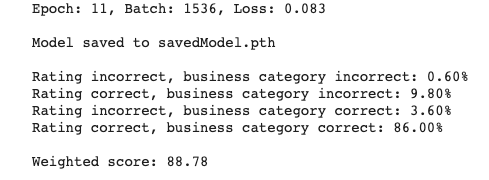

In [17]:
from PIL import Image

score = Image.open('final_score.png')
score 

# References <a class="anchor" id="ref"></a>

Paszke, A, et al. 2019, PyTorch: An Imperative Style, High-Performance Deep Learning Library, *Neural Information Processing Systems*, no. 32, pp. 8024–8035, accessed 10 September 2021, [website](http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf).

Lane, H, Howard, C and Hapke, H 2019, *Natural Language Processing in Action*, Manning Publications, Shelter Island, NY, USA. 

Pennington, J, Socher, R and Manning, CD 2014, *GloVe: Global Vectors for Word Representation*, [website](http://nlp.stanford.edu/projects/glove/).

Graves, A 2011, Practical Variational Inference for Neural Networks, *Advances in Neural Information Processing Systems 24*, pp. 2348-2356, accessed 7 October 2021, [website](http://proceedings.neurips.cc/paper/2011/file/7eb3c8be3d411e8ebfab08eba5f49632-Paper.pdf).

Glassner, A 2021, *Deep Learning: A Visual Approach*, No Starch Press, San Francisco, Ca, USA.

He, K, Zhang, X, Ren, S and Sun, J 2015, Delving deep into rectifiers: Surpassing human-level performance on imagenet classification, *Proceedings of the IEEE International Conference on Computer Vision*, pp. 1026-1034, accessed 10 September 2021, [website](http://arxiv.org/pdf/1502.01852.pdf).  

